#### Идеи
- Признак: совпадает ли город регистрации автомобиля и водителя (column_4,column_5)
- Признак: нет просточек по выплатам (column_6)
- Признак: Маленький пробег (порог "маленький" подобрать) (column_8)
- Признак: Возраст больше 100 лет/или порога (column_13)
- Попробовать смерждить с соревнованием 2 и добавить столбец страховой случай done (общих полей не много)
- Совпадения трейн и тест

# 1-task
## Описание полей

- `column_1` - пол водителя;
- `column_2` - стаж вождения;
- `column_3` - семейное положение водителя;
- `column_4` - город регистрации водителя;
- `column_5` - город регистрации договора;
- `column_6` - максимальная просрочка по выплатам;
- `column_7` - тип двигателя;
- `column_8` - пробег транспортного средства;
- `column_9` - год производства транспортного средства;
- `column_10` - мощность двигателя в лошадиных силах;
- `column_11` - количество договоров клиента;
- `column_12` - количество договоров транспортного средства;
- `column_13` - возраст клиента;
- `column_14` - тип транспортного средства;
- `column_15` - страна-производитель транспортного средства;
- `column_16` - наличие телематических систем, установленных на транспортное средство;
- `column_17` - марка и модель автомобиля (задача усложняется тем, что в выборке почти для всех марок присутствуют разные модели, представляющие их, т.е. марка X в выборке представлена моделями x1,x2, хотя в явном виде эта информация в данных не присутствует);
- `column_18` - технический параметр транспортного средства.

- <font color="red">`target` - страховая стоимость транспортного средства 
    
    
Для 24 511 договоров страхования транспортных средств известны значения ряда признаков, в том числе пол, возраст, стаж вождения и коэффициент бонус-малус водителя, тип, марка, модель, год выпуска, страна – производитель, мощность и объем двигателя, а также страховая стоимость транспортного средства 

Метрикой качества является средняя относительная ошибка предсказания `MAPE`

____

## Импорт библиотек и загрузка данных

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
import numpy as np


PATH_TO_DATA="/Users/roman/finunichamp2018/1/data/"

In [2]:
train=pd.read_csv(PATH_TO_DATA+"insvalue_train.csv")
test=pd.read_csv(PATH_TO_DATA+"insvalue_test.csv")
sample_submit=pd.read_csv(PATH_TO_DATA+"insvalue_sample.csv")

In [3]:
train.head(2)

,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,target
0,2,15.065199,a1,b0,b0,53.0,q2,1.0,2,249.0,23,1,58.025786,1,c4,1,k,3.095619,3.105288e+06
1,1,12.200897,a3,b0,b0,6.0,q1,2100.0,4,123.0,4,3,81.549097,1,c0,0,a,1.665975,3.752557e+05


## EDA

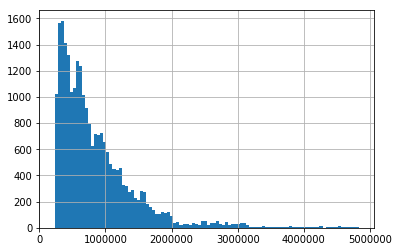

In [4]:
train["target"].hist(bins=100);

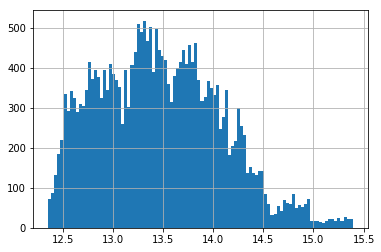

In [5]:
np.log(train["target"]).hist(bins=100);

Скорее всего целевой признок нужно прологарифмировать

In [6]:
#Только в одном столбце  "column_2" есть пропуски
train.isnull().any()

column_1     False
column_2      True
column_3     False
column_4     False
column_5     False
column_6     False
column_7     False
column_8     False
column_9     False
column_10    False
column_11    False
column_12    False
column_13    False
column_14    False
column_15    False
column_16    False
column_17    False
column_18    False
target       False
dtype: bool

In [7]:
#В тесте в column_2 и column_8 есть пропуски
test.isnull().any()

id           False
column_1     False
column_2      True
column_3     False
column_4     False
column_5     False
column_6     False
column_7     False
column_8      True
column_9     False
column_10    False
column_11    False
column_12    False
column_13    False
column_14    False
column_15    False
column_16    False
column_17    False
column_18    False
dtype: bool

## Обработка данных

### Добавление признака класса для классификатора

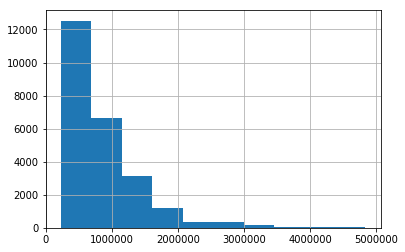

In [8]:
train["target"].hist();

In [ ]:
#по факту на 2 класса
train["target"]=np.log(train["target"])

#Старое не делоая лог норм
# threshold_one_class=1500000   
# threshold_three_class=3000000 

threshold_one_class=14.5
threshold_three_class=14.5

train["class"]=0

index=train[train["target"]<threshold_one_class].index
train["class"][index]=np.ones_like(index)


index=train[train["target"]>threshold_three_class].index
train["class"][index]=np.ones_like(index)*3

train["class"]=train["class"].apply(lambda x:2 if x==0 else x)

train["target"]=np.exp(train["target"])

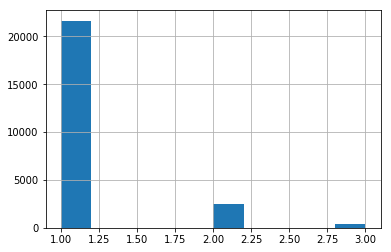

In [12]:
train["class"].hist();

### В каких столбцаз есть пропуски
- `column_2` xgb-оставить, деревянные-вне распределения,lin-средним

### Какие столбцы какого типа
- Вещественные `column_2`,`column_6`,`column_8`,`column_10`,`column_11`,`column_12`,`column_13`,`column_18`

- Категориальные `column_1`,`column_3`,`column_4`(822),`column_5`(789),`column_7`,`column_9`,`column_15`,`column_16`,`column_17`,`same_town`,`no_debts`

### Как обрабатывать
- `column_1`  - OHE-lin tree,xgb,catboost-оставить `done`
- `column_2`  - оставить
- `column_3`  - OHE-lin,tree,xgb  catboost-оставить
- `column_4`  - OHE-lin,tree,xgb  catboost-оставить (или выкинуть вообще)
- `column_5`  - OHE-lin,tree,xgb  catboost-оставить (или выкинуть вообще)
- `column_6`  - оставить
- `column_7`  - OHE-lin,tree,xgb  catboost-оставить
- `column_8`  - оставить
- `column_9`  - OHE-lin,tree,xgb  catboost-оставить (или оставить для всех как вещественный признак)
- `column_10` - оставить
- `column_11` - оставить
- `column_12` - оставить (OHE-lin,tree,xgb  catboost-оставить)
- `column_13` - оставить
- `column_14` - выбросить тк значение константа
- `column_15` - OHE-lin,tree,xgb  catboost-оставить
- `column_16` - OHE-lin,tree,xgb  catboost-оставить
- `column_17` - OHE-lin,tree,xgb  catboost-оставить (или выкинуть тк модель не учитываеться)
- `column_18` - оставить

### Генерация фич
- совпадает ли город регистрации автомобиля и водителя (column_4,column_5) `done`
- нет просточек по выплатам (column_6)`done`
- Маленький пробег (порог "маленький" подобрать) (column_8)
- Возраст больше 100 лет/или порога (column_13)

In [13]:
#Объеденение test и train для последующей обработки
test.drop("id",axis=1,inplace=True)

sep=train.shape[0]

df=pd.concat([train.drop(["target","class"],axis=1),test])


y=train["target"]
classes=train["class"]

In [14]:
#1
column_1_lin=pd.get_dummies(df["column_1"],prefix="col1")
column_1_tree=df["column_1"]
column_1_xgb=column_1_tree
column_1_cat=column_1_tree
#2
column_2_lin=df["column_2"].fillna(df["column_2"].mean())
column_2_tree=df["column_2"].fillna(200) #max 83
column_2_xgb=column_2_tree
column_2_cat=column_2_tree
#3
column_3_lin=pd.get_dummies(df["column_3"],prefix="col_3")
column_3_tree=column_3_lin
column_3_xgb=column_3_lin
column_3_cat=df["column_3"]
#4
column_4_lin=pd.get_dummies(df["column_4"],prefix="col_4")
column_4_tree=column_4_lin
column_4_xgb=column_4_lin
column_4_cat=df["column_4"]
#5
column_5_lin=pd.get_dummies(df["column_5"],prefix="col_5")
column_5_tree=column_5_lin
column_5_xgb=column_5_lin
column_5_cat=df["column_5"]
#new feature
same_town_lin=pd.get_dummies((df["column_4"]==df["column_5"]).astype(int),prefix="same_town")
same_town_tree=(df["column_4"]==df["column_5"]).astype(int)
same_town_xgb=same_town_tree
same_town_cat=same_town_tree
#6
column_6_lin=df["column_6"]
column_6_tree=column_6_lin
column_6_xgb=column_6_lin
column_6_cat=column_6_lin
#new feature
no_debts_lin=pd.get_dummies((df["column_6"]==0).astype(int),prefix="no_debts")
no_debts_tree=(df["column_6"]==0).astype(int)
no_debts_xgb=no_debts_tree
no_debts_cat=no_debts_tree
#7
column_7_lin=pd.get_dummies(df["column_7"],prefix="col_7")
column_7_tree=column_7_lin
column_7_xgb=column_7_lin
column_7_cat=df["column_7"]
#8
column_8_lin=df["column_8"].fillna(df["column_8"].mean()) #Всего 3 записи с пропусками
column_8_tree=column_8_lin
column_8_xgb=column_8_lin
column_8_cat=column_8_lin
#9
column_9_lin=pd.get_dummies(df["column_9"],prefix="col_9_year")
column_9_tree=column_9_lin
column_9_xgb=column_9_lin
column_9_cat=df["column_9"]
#10
column_10_lin=df["column_10"]
column_10_tree=column_10_lin
column_10_xgb=column_10_lin
column_10_cat=column_10_lin
#11
column_11_lin=df["column_11"]
column_11_tree=column_11_lin
column_11_xgb=column_11_lin
column_11_cat=column_11_lin
#12
column_12_lin=df["column_12"]
column_12_tree=column_12_lin
column_12_xgb=column_12_lin
column_12_cat=column_12_lin
#13
column_13_lin=df["column_13"]
column_13_tree=column_13_lin
column_13_xgb=column_13_lin
column_13_cat=column_13_lin
#15
column_15_lin=pd.get_dummies(df["column_15"],prefix="col_15")
column_15_tree=column_15_lin
column_15_xgb=column_15_lin
column_15_cat=df["column_15"]
#16
column_16_lin=pd.get_dummies(df["column_16"],prefix="col_16")
column_16_tree=column_16_lin
column_16_xgb=column_16_lin
column_16_cat=df["column_16"]
#17
column_17_lin=pd.get_dummies(df["column_17"],prefix="col_17")
column_17_tree=column_17_lin
column_17_xgb=column_17_lin
column_17_cat=df["column_17"]
#18
column_18_lin=df["column_18"]
column_18_tree=column_18_lin
column_18_xgb=column_18_lin
column_18_cat=column_18_lin

### Формирование датасетов

In [15]:
X_lin= pd.concat([column_1_lin,
                  column_2_lin,
                  column_3_lin,
                  column_4_lin,
                  column_5_lin,
                  same_town_lin,
                  column_6_lin,
                  no_debts_lin,
                  column_7_lin,
                  column_8_lin,
                  column_9_lin,
                  column_10_lin,
                  column_11_lin,
                  column_12_lin,
                  column_13_lin,
                  column_15_lin,
                  column_16_lin,
                  column_17_lin,
                  column_18_lin],axis=1)

X_tree=pd.concat([column_1_tree,
                  column_2_tree,
                  column_3_tree,
                  column_4_tree,
                  column_5_tree,
                  same_town_tree,
                  column_6_tree,
                  no_debts_tree,
                  column_7_tree,
                  column_8_tree,
                  column_9_tree,
                  column_10_tree,
                  column_11_tree,
                  column_12_tree,
                  column_13_tree,
                  column_15_tree,
                  column_16_tree,
                  column_17_tree,
                  column_18_tree],axis=1)

X_xgb= pd.concat([column_1_xgb,
                  column_2_xgb,
                  column_3_xgb,
                  column_4_xgb,
                  column_5_xgb,
                  same_town_xgb,
                  column_6_xgb,
                  no_debts_xgb,
                  column_7_xgb,
                  column_8_xgb,
                  column_9_xgb,
                  column_10_xgb,
                  column_11_xgb,
                  column_12_xgb,
                  column_13_xgb,
                  column_15_xgb,
                  column_16_xgb,
                  column_17_xgb,
                  column_18_xgb],axis=1)

X_cat= pd.concat([column_1_cat,
                  column_2_cat,
                  column_3_cat,
                  column_4_cat,
                  column_5_cat,
                  same_town_cat,
                  column_6_cat,
                  no_debts_cat,
                  column_7_cat,
                  column_8_cat,
                  column_9_cat,
                  column_10_cat,
                  column_11_cat,
                  column_12_cat,
                  column_13_cat,
                  column_15_cat,
                  column_16_cat,
                  column_17_cat,
                  column_18_cat],axis=1)

In [16]:
X_train_lin=X_lin[:sep]
X_test_lin=X_lin[sep:]

X_train_tree=X_tree[:sep]
X_test_tree=X_tree[sep:]

X_train_xgb=X_xgb[:sep]
X_test_xgb=X_xgb[sep:]

X_train_cat=X_cat[:sep]
X_test_cat=X_cat[sep:]

In [17]:
X_train_lin.to_csv(PATH_TO_DATA+"X_train_lin.csv",index=False)
X_test_lin.to_csv(PATH_TO_DATA+"X_test_lin.csv",index=False)

X_train_tree.to_csv(PATH_TO_DATA+"X_train_tree.csv",index=False)
X_test_tree.to_csv(PATH_TO_DATA+"X_test_tree.csv",index=False)

X_train_xgb.to_csv(PATH_TO_DATA+"X_train_xgb.csv",index=False)
X_test_xgb.to_csv(PATH_TO_DATA+"X_test_xgb.csv",index=False)

X_train_cat.to_csv(PATH_TO_DATA+"X_train_cat.csv",index=False)
X_test_cat.to_csv(PATH_TO_DATA+"X_test_cat.csv",index=False)

y.to_csv(PATH_TO_DATA+"Y.csv",header=True,index=False)
classes.to_csv(PATH_TO_DATA+"classes.csv",header=True,index=False)